# Identify working and data directory and site ID.
* The working directory is the root directory of the github.
* The data directory points to the google drive folder where the larger data files are stored.
* For the moment the site ID if the four-digit NEON site ID.

In [1]:
working<-"~/neon_suna"
site_id<-"KING"
data<-paste("~/gdrive/SUNA_Data/SUNA_NEON/",site_id,"/2019",sep="")


# Initialize required libraries, functions and formatting utilities.

In [2]:
library(dplyr)
library(streamMetabolizer)
library(splitstackshape)
library(ggplot2)
library(lubridate)
library(reshape2)
library(neonUtilities)
library(progress)
library(patchwork)
library(doBy)
#library(box)

theme_ts_space<-theme_grey() +
		theme(
#		panel.grid.major = element_blank(),
#		panel.grid.minor = element_blank(),
		panel.background = element_rect(fill="white", colour="black", size=2),
#		legend.key       = element_blank(),
#		legend.text      = element_text(size=20.5),
#		legend.text      = element_blank(),
#		legend.title     = element_text(size=20.5),
		axis.text.x = element_text(size=22,colour="black",hjust=1,angle=45),
		axis.text.y = element_text(size=22,colour="black",vjust=.3),
		axis.title.x = element_text(size=22),
		axis.title.y = element_text(size=22,vjust=-1),
#		plot.title = element_text(hjust = 0.5,size=22,face="bold"),		
#		legend.position  = "left",
		legend.position  = "none",
		plot.margin = unit(c(1,1,1,1), "cm"),
		panel.border = element_rect(colour = "black", fill=NA, size=2)
		)






Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


USGS Active Research Package:
https://owi.usgs.gov/R/packages.html#research

This package was developed for research purposes. We used it for our
own applications and welcome flexible, resilient users who can help us
test and improve the package. Please give us feedback at
https://github.com/USGS-R/streamMetabolizer/issues/new.


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by




# Setting up the workspace
In the cell below indicate the site that will be analyzed here according to its NEON 4-letter code. A list of files for that site is then placed in the vector "sunas".

If you downloaded the repo into your home director, which is found by going to "~/", then you don"t have to change the box path. FYI: Box is a new package for R that allows you to define a set of functions without creating a new package.

In [3]:

#setwd(paste("~/gdrive/SUNA_data/SUNA_NEON/",site_id,sep=""))
#sunas<-list.files(pattern="*.csv")
#getwd()
#options(box.path = "~/neon_suna/box/")
#box::use(plots)

setwd(data)
sunas<-list.files(pattern="*.CSV")

#suna_cal<-readRDS("/Users/jhosen/gdrive/fdom/SUNA Calibration pdfs/suna_cal_comb.rds")
suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA Calibration pdfs/suna_0839_20200312.csv")
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]

# Data import and processing loop.
This step loads each data file, formats the data for use, and concatenates files from an individual site.

This step could take a while.

In [5]:
#head(suna[,c(260:274)])
#length(c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time",suna_cal$Wavelength,"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum"))
head(suna)

,suna_id,date,time,nitrate,nitrate_mgl,a254,a350,bromide_trace,spec_average_dark,dark_signal_average,⋯,fit_aux_2,fit_base_1,fit_base_2,fit_RMSE,CTD_Time,CTD_Salinity,CTD_Temp,CTD_Pressure,checksum,dtp
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<dttm>
1,SATSLF1207,2019032,18.50984,2.63,0.0368,0.0321,0.0251,0,19785,734,⋯,-1,7.5779,-1.847449,0.000199,NA,NA,NA,NA,158,2019-02-01 18:30:35
2,SATSLF1207,2019032,18.51011,2.62,0.0366,0.0326,0.0243,0,19778,734,⋯,-1,7.6305,-1.856307,0.000220,NA,NA,NA,NA,113,2019-02-01 18:30:36
3,SATSLF1207,2019032,18.51038,2.73,0.0382,0.0329,0.0247,0,19765,734,⋯,-1,7.3814,-1.737374,0.000165,NA,NA,NA,NA,178,2019-02-01 18:30:37
4,SATSLF1207,2019032,18.51066,2.65,0.0371,0.0323,0.0244,0,19778,734,⋯,-1,7.7641,-1.904835,0.000212,NA,NA,NA,NA,110,2019-02-01 18:30:38
5,SATSLF1207,2019032,18.51093,2.64,0.0370,0.0324,0.0244,0,19775,734,⋯,-1,7.8082,-1.916989,0.000174,NA,NA,NA,NA,71,2019-02-01 18:30:39
6,SATSLF1207,2019032,18.51121,2.71,0.0379,0.0325,0.0244,0,19778,734,⋯,-1,7.4962,-1.785586,0.000217,NA,NA,NA,NA,59,2019-02-01 18:30:40


In [4]:
options(warn=-1)
compiled_suna<-data.frame()
sunas_length<-length(sunas)
for(i in 1:sunas_length){
#i<-1
print(i)
suna<-read.csv(paste(sunas[i]),skip=14,header=FALSE)
#head(suna)

#suna_d0<-cSplit(suna,3, ",")
#names(suna)<-c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time",suna_cal$Wavelength,"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum")
names(suna)<-c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time",seq(188,395,length.out=256),"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum")

#suna<-subset(suna,a254!=0)

suna<-subset(suna,a254!=0)

#year<-substr(suna$date, 1, 4)
if(grepl("D2016",sunas[i])==TRUE){
year<-"2016"
doy<-gsub(".CSV","",gsub("D2016","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}    
    
    
#year<-substr(suna$date, 1, 4)
if(grepl("D2019",sunas[i])==TRUE){
year<-"2019"
doy<-gsub(".CSV","",gsub("D2019","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}
    
if(grepl("D2020",sunas[i])==TRUE){
year<-"2020"
doy<-gsub(".CSV","",gsub("D2020","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}

day<-as.POSIXct(paste(as.Date(as.numeric(doy)-1,origin=paste(year,"-01-01",sep="")),"00:00:00"),tz="UTC")
#suna$day<-as.POSIXct("2019-05-10 00:00:00",tz="UTC")
suna$dtp<-day + (3600*as.numeric(suna$time))
#attr(suna$dtp,"tzone") <- "Etc/GMT+8"

    

offse<-c(t(suna_cal_t[3,]))
suna2<-(suna[,12:267]/suna$int_time)-suna$dark_signal_average
suna_d0_norm<-sweep(suna2,2,FUN="/",offse)
names(suna_d0_norm)<-paste("n_",names(suna_cal_t),sep="")

    

#print("test")
suna_d0_int<-data.frame()
for(j in 1:nrow(suna_d0_norm)){	
#    print(j)
	flip<-as.data.frame(t(suna_d0_norm[j,]))
	names(flip)<-c("abs")
	flip$wl_nm<-gsub("n_","",row.names(flip),fixed=TRUE)
	flip_int<-as.data.frame(t(approx(flip$wl_nm,flip$abs,xout=seq(189,394,1),rule=2)$y))
	names(flip_int)<-paste("interp_",seq(189,394,1),sep="")
	suna_d0_int<-bind_rows(suna_d0_int,flip_int)
}
suna_d<-bind_cols(suna,suna_d0_int)
#suna_d$date<-as.character(suna_d[,c("date")])
#suna_d$time<-as.character(suna_d[,c("time")])
suna_d2<-suna_d %>% mutate_if(is.numeric,as.character)
compiled_suna<-bind_rows(compiled_suna,suna_d2)
}
print("done")
options(warn=0)    
    
    
    


[1] 1
[1] "done"


# Check Data and Save

In [ ]:
#i
#grepl("D2020",sunas[240])
#sunas[240]
#length(sunas)
#sunas[240]
#ncol(compiled_suna)
#nrow(compiled_suna)
saveRDS(compiled_suna,"/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/KING/SUNA_KING_20210428_full.rds")
compiled_suna<-readRDS("/Users/jhosen/gdrive/SUNA_Data/corrected_files/SUNA_Cor/SUNA_KING_20210428_full.rds")


# Extracting the interpolated columns

In [5]:
compiled_suna$cal<-"suna_0839"

suna_interp<-compiled_suna[,grepl("^inter",names(compiled_suna))] %>% mutate_if(is.character, ~as.numeric(.))
#head(suna_interp)

other_suna<-compiled_suna[,c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time","sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum","cal","dtp")]

suna_cols<-bind_cols(other_suna,suna_interp)
suna_cols$a254<-as.numeric(suna_cols$a254)
suna_cols$a350<-as.numeric(suna_cols$a350)
suna_cols$nitrate<-as.numeric(suna_cols$nitrate)
suna_cols$nitrate_mgl<-as.numeric(suna_cols$nitrate_mgl)
suna_cols$sensor_temp<-as.numeric(suna_cols$sensor_temp)


In [8]:
suna_cols<-subset(suna_cols,a254<10)


a350_mod<-lm(a350~log10(interp_350)+I(log10(interp_350)^2)+I(log10(interp_350)^3),suna_cols)
a254_mod<-lm(a254~log10(interp_254)+I(log10(interp_254)^2)+I(log10(interp_254)^3),suna_cols)



cor_cols<-grep("^interp_",names(suna_cols))


Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in unique.default(c("AsIs", oldClass(x))):
“NaNs produced”
Warning message in unique.default(c("AsIs", oldClass(x))):
“NaNs produced”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in unique.default(c("AsIs", oldClass(x))):
“NaNs produced”
Warning message in unique.default(c("AsIs", oldClass(x))):
“NaNs produced”



Call:
lm(formula = a254 ~ log10(interp_254) + I(log10(interp_254)^2) + 
    I(log10(interp_254)^3), data = suna_cols)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4327 -0.0256 -0.0029  0.0125  1.9600 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.0444931  0.0001097   405.5   <2e-16 ***
log10(interp_254)      -0.1208818  0.0003354  -360.4   <2e-16 ***
I(log10(interp_254)^2)  0.1728899  0.0002945   587.1   <2e-16 ***
I(log10(interp_254)^3) -0.0467313  0.0001039  -449.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07063 on 567955 degrees of freedom
  (2657 observations deleted due to missingness)
Multiple R-squared:  0.4138,	Adjusted R-squared:  0.4138 
F-statistic: 1.336e+05 on 3 and 567955 DF,  p-value: < 2.2e-16


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-3.432661 -0.025578 -0.002874  0.000000  0.012534  1.959973 


Call:
lm(formula = a350 ~ log10(interp_350) + I(log10(interp_350)^2) + 
    I(log10(interp_350)^3), data = suna_cols)

Residuals:
   Min     1Q Median     3Q    Max 
-8.365 -0.019  0.000  0.013 91.891 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.0022592  0.0001990   11.35   <2e-16 ***
log10(interp_350)      -0.0211863  0.0006229  -34.01   <2e-16 ***
I(log10(interp_350)^2)  0.2066381  0.0006060  341.01   <2e-16 ***
I(log10(interp_350)^3) -0.0772429  0.0002605 -296.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1364 on 568053 degrees of freedom
  (2559 observations deleted due to missingness)
Multiple R-squared:  0.1752,	Adjusted R-squared:  0.1752 
F-statistic: 4.022e+04 on 3 and 568053 DF,  p-value: < 2.2e-16


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-8.36506 -0.01936 -0.00017  0.00000  0.01348 91.89104 

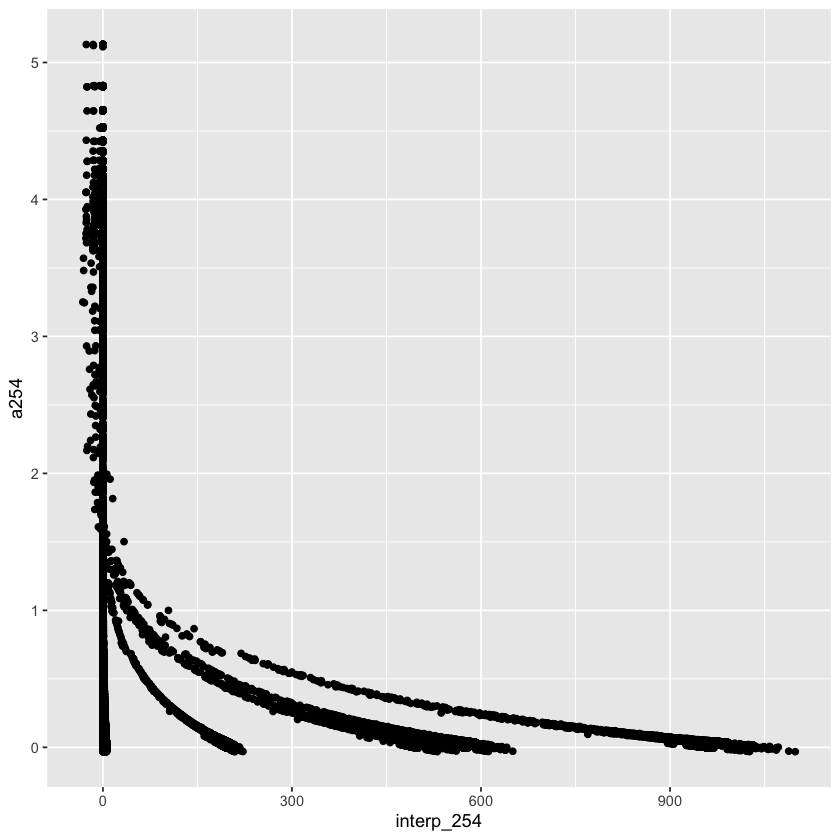

In [9]:
ggplot(suna_cols,aes(interp_254,a254))+geom_point()

summary(a254_mod)
summary(resid(a254_mod))

summary(a350_mod)
summary(resid(a350_mod))

In [ ]:

#compiled_suna2[,c(cor_cols)]<-compiled_suna2[,c(cor_cols)] %>% mutate_if(is.character,as.numeric)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_350=suna_cols[,cor_cols[i]],interp_254=suna_cols[,cor_cols[i]])
	a350_pred<-predict(a350_mod,newdata=prepdata)
	a254_pred<-predict(a254_mod,newdata=prepdata)
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c350",sep=""))]<-a350_pred
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c254",sep=""))]<-a254_pred
}



# Reducing data down to 15 minutes intervals.
We want to average down each burst from the SUNA to a single value and mac sure that these values are snapped to 15 minutes intervals (e.g., rather than round up or down to 14 or 16).

In [ ]:
str(suna_cols$sensor_temp)

In [ ]:
rm(compiled_suna)
rm(compiled_suna_1)
rm(compiled_suna_2)

suna_cols$dtpr<-lubridate::round_date(suna_cols$dtp, "15 minutes")
suna_red<-summaryBy(.~dtpr,suna_cols,FUN=c(mean))



# Downloading turbidity time series data from NEON.
Data product DP1.20288.001 for general water quality sonde data.

In [ ]:
#KING_wqs<-loadByProduct(dpID="DP1.20288.001",site="KING",check.size=F)
#saveRDS(KING_wqs,paste(data,"/KING_wqs.rds",sep=""))
KING_wqs<-readRDS(paste(data,"/KING_wqs.rds",sep=""))


In [ ]:
KING_wqsd<-KING_wqs$waq_instantaneous
KING_wqsd$dtp<-KING_wqsd$startDateTime
KING_wqk<-subset(KING_wqsd[,c("siteID","dtp","specificConductance","dissolvedOxygen","pH","chlorophyll","turbidity","fDOM")],!is.na(KING_wqsd$specificConductance))
#str(KING_wqk)

KING_wqk$dtpr<-lubridate::round_date(KING_wqk$dtp, "15 minutes")
KING_wq_red<-summaryBy(.~dtpr,KING_wqk,FUN=c(mean))
str(KING_wq_red)

In [ ]:
KING_sw<-merge(suna_red,KING_wq_red,by="dtpr",all.x=TRUE)


# import and merge NEON water quality grab sample data.

### Downloading grab sample data and saving as rds file in data folder.

In [ ]:


library(zoo)
#KING_wqg<-loadByProduct(dpID="DP1.20093.001",site="KING",check.size=F)
#saveRDS(KING_wqg,paste(data,"/KING_wqg.rds",sep=""))
KING_wqg<-readRDS(paste(data,"/KING_wqg.rds",sep=""))



### extracting lab analysis data

In [ ]:
KING_wqg_d<-as.data.frame(KING_wqg$swc_externalLabDataByAnalyte)

names(KING_wqg_d)

uv_abs<-subset(KING_wqg_d,analyte=="UV Absorbance (250 nm)"|analyte=="UV Absorbance (280 nm)")
date_cast<-dcast(uv_abs[,c("analyte","collectDate","analyteConcentration")],collectDate~analyte,value.var="analyteConcentration",mean)
date_cast$dtpr<-lubridate::round_date(date_cast$collectDate, "15 minutes")

names(date_cast)

In [ ]:

suna_grab<-merge(KING_sw,date_cast,by="dtpr")

#temp_nitrate_zoo<-zoo(nitrate$nitrate_umL,nitrate$dtp)
#temp_n<-na.approx(temp_nitrate_zoo,xout=suna_red$dtp,na.rm=FALSE)
#suna_grab[,c("UV Absorbance (250 nm)")]
names(suna_grab)<-gsub("UV Absorbance (250 nm)","uva_250_lab",names(suna_grab),fixed=TRUE)
names(suna_grab)<-gsub("UV Absorbance (280 nm)","uva_280_lab",names(suna_grab),fixed=TRUE)



# Exploring turbidity corrections

In [ ]:
#names(suna_grab)
suna_grab<-subset(suna_grab,!is.na(uva_250_lab)&!is.na(uva_280_lab)&uva_250_lab<2)
suna_grab$turbidity.mean[suna_grab$turbidity.mean<=0]<-1
suna_grab[,c("dtpr","a254.mean","uva_250_lab","uva_280_lab","interp_250_c254.mean","turbidity.mean")]

suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)
nrow(suna_grab)
suna_grab$uva_250_lab
#suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


In [ ]:
suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)


summary(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))
summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean,color=pH.mean))+
theme_ts_space+
xlab("\nUV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Uncorrected)\n")+
geom_point(size=6)

ggsave("~/neon_suna/plots/KING_250_uncorrected.pdf",width = 20, height = 20, units = "cm")



ggplot(suna_grab,aes(uva_250_lab,interp_250_tcorr_log,color=pH.mean))+
theme_ts_space+
geom_smooth(method="lm",color="grey20")+
xlab("\nUV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Corrected)\n")+
geom_point(size=6)+
ggtitle("Turbidity Corrected")

ggsave("~/neon_suna/plots/KING_250_corrected.pdf",width = 20, height = 20, units = "cm")




#summary(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c350.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))

In [ ]:
names(KING_sw)

# Apply turbidity correction based on lab samples.

In [ ]:
cor_cols<-grep("^interp_",names(KING_sw))

uva_250_turb_lm<-lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_250_log=log10(KING_sw[,cor_cols[i]]),turbidity.mean=KING_sw$turbidity.mean)
	turb_cor_pred<-predict(uva_250_turb_lm,newdata=prepdata)
	KING_sw[,c(paste(names(KING_sw)[cor_cols[i]],"_turb",sep=""))]<-turb_cor_pred
}



In [ ]:
head(KING_sw)

In [ ]:
KING_swt_0<-KING_sw[,grep("*_turb$",names(KING_sw))]
KING_swt<-bind_cols(KING_sw[,c("dtpr","nitrate.mean","nitrate_mgl.mean","a254.mean","a350.mean","sensor_temp.mean","specificConductance.mean","dissolvedOxygen.mean","pH.mean","chlorophyll.mean","turbidity.mean","fDOM.mean")],KING_swt_0)





# Adding PAR data.

In [ ]:
KING_par<-loadByProduct(dpID="DP1.20042.001",site="KING",check.size=F)
saveRDS(KING_par,paste(getwd(),"/KING_par.rds",sep=""))
KING_par<-readRDS(paste(getwd(),"/KING_par.rds",sep=""))




In [ ]:
#lubridate::round_date(KING_parts$dtp, "15 minutes")


In [ ]:

KING_parts<-KING_par$PARWS_5min
KING_parts$dtp<-KING_parts$startDateTime
#str(KING_wqk)



KING_parts$dtpr<-lubridate::round_date(KING_parts$dtp, "15 minutes")
KING_parts_red<-summaryBy(PARMean~dtpr,KING_parts,FUN=c(mean))
head(KING_parts_red)
#str(KING_wq_red)

KING_swtpar<-merge(KING_swt,KING_parts_red,by="dtpr",all.x=TRUE)


In [ ]:

str(KING_swtpar$dtpr)

attr(KING_swtpar$dtpr,"tzone") <- "Etc/GMT+5"

str(KING_swtpar$dtpr)
KING_swtpar$date<-as.Date(KING_swtpar$dtpr,tz="Etc/GMT+5")

KING_dates<-unique(KING_swtpar$date)

for(i in 1:length(KING_dates)){
    
    
}

In [ ]:

#KINGd<-subset(KING_swtpar,date==as.Date("2019-06-10"))
KINGd<-KING_swtpar

KINGdk<-KINGd[,grep("*c254.mean_turb$",names(KINGd))]
KINGdk$dtpr<-KINGd$dtpr

KINGdm<-subset(melt(KINGdk,id.vars=c("dtpr")),!is.na(value))
KINGdm$wavelength<-gsub("interp_","",KINGdm$variable,fixed=TRUE)
KINGdm$wavelength<-as.numeric(gsub("_c254.mean_turb","",KINGdm$wavelength,fixed=TRUE))



str(KINGdm)

# Trying some ridge plots to look at wavelength changes over time.
So far not looking super great.

In [ ]:
#library(ggridges)
#scales::rescale(height)
#KINGdm$dtprn<-scales::rescale(as.numeric(KINGdm$dtpr))
#KINGdm$abs<-scales::rescale(as.numeric(KINGdm$value))


#ggplot(subset(KINGdm,wavelength>=275&wavelength<=295),aes(x = wavelength, y = dtprn, group=dtprn,height = abs)) +
#  geom_ridgeline(fill="grey80",alpha=0.6)

#ggsave("~/neon_suna/plots/KINGdm_ridge.pdf",width = 20, height = 40, units = "cm")


# Calculating spectral slope 275-295nm on each time step.

In [ ]:
names(KINGd)
names(KINGdm)

In [ ]:
ssm_275_295<-subset(KINGdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()


for(i in 1:length(dtps)){
	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()
}	
	


In [ ]:
nrow(s275295_comp)
nrow(KING_swtpar)
KING_swtp_ss<-merge(KING_swtpar,s275295_comp,by="dtpr",all.x=TRUE)
saveRDS(KING_swtp_ss,paste(data,"KING_swtp_ss.rds",sep=""))

# Extracting spectral daily slope ratio discrepancy.

In [ ]:
sdates<-unique(as.Date(KING_swtp_ss$dtpr,tz="Etc/GMT+5"))

#i<-30
comp_df<-data.frame()
for(i in 1:length(sdates)){
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
KINGday<-subset(KING_swtp_ss,dtpr>=start & dtpr<=finish)
KINGday<-subset(KINGday,!is.na(PARMean.mean) & !is.na(s275295))

if(nrow(KINGday)>80){
    KINGday$PAR_roll<-as.numeric(c("NA",rollmean(KINGday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    KINGday$s275295_roll<-as.numeric(c("NA",rollmean(KINGday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    KING_night<-subset(KINGday,PARMean.mean<200)
    night_s275295<-mean(KING_night$s275295,na.rm=TRUE)
    
    #KINGday$baseline<-predict(lm(s275295~dtpr,KING_night),KINGday)
    KINGday$baseline_roll<-predict(lm(s275295_roll~dtpr,KING_night),KINGday)    
    KINGday$s275295_bs<-KINGday$s275295_roll-KINGday$baseline_roll    
    
    KING_night_am<-subset(KING_night,hour(dtpr)<=12)
    night_s275295_am<-mean(KING_night_am$s275295,na.rm=TRUE)
    
    KING_night_pm<-subset(KING_night,hour(dtpr)>12)
    night_s275295_pm<-mean(KING_night_pm$s275295,na.rm=TRUE)
    
    KING_day<-subset(KINGday,PARMean.mean>=10)
    day_s275295<-mean(KING_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(KING_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(KING_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,KING_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,KING_day)$coef[2]    
    
    KING_n_am_time<-nrow(KING_night_am)
    KING_n_pm_time<-nrow(KING_night_pm)
    KING_d_time<-nrow(KING_day)
    
    temp_df<-data.frame(site="KING",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,KING_n_am_time=KING_n_am_time,KING_n_pm_time=KING_n_pm_time,KING_d_time=KING_d_time)
    comp_df<-bind_rows(comp_df,temp_df)
    }
}




In [ ]:
    KING_day$s275295_bs
ggplot(comp_df,aes(date,day_s275295_base_sum))+
       geom_point(size=2)
ggplot(comp_df,aes(date,day_PAR_roll_base_sum))+
       geom_point(size=2)


ggplot(comp_df,aes(day_PAR_roll_base_sum,day_s275295_base_sum))+
geom_point()


saveRDS(comp_df,paste(data,"comp_df_KING.rds",sep=""))

In [ ]:
KINGday<-subset(KING_swtp_ss,as.Date(dtpr,tz="Etc/GMT+5")==as.Date("2019-06-11",tz="Etc/GMT+5"))
nrow(KINGday)

str(KINGday$s275295)



ggplot(KINGday,aes(dtpr,s275295))+
geom_point()


ggplot(KINGday,aes(dtpr,PARMean.mean))+
geom_point()

